In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

## Import Data

In [61]:
fnames = ['/Users/hkromer/02_PhD/02_Data/08.Microwave.PermanentMagnets/Messung01_magneticField.txt', '/Users/hkromer/02_PhD/02_Data/08.Microwave.PermanentMagnets/Messung02_magneticField.txt']

In [62]:
dfs = []
for fname in fnames:
    df = pd.read_csv(fname, skiprows=0, delimiter='\t')
    df.iloc[:,1] = df.iloc[:,1] * 1000 # convert to Gauss
    dfs.append(df)


## Plot

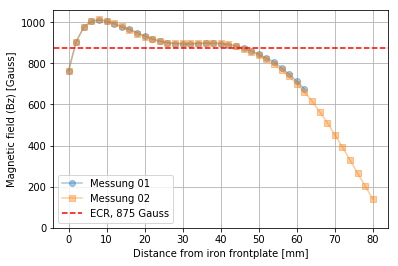

In [63]:
plt.plot(dfs[0].iloc[:,0], dfs[0].iloc[:,1], marker='o',label='Messung 01', alpha=0.4)

plt.plot(dfs[1].iloc[:,0], dfs[1].iloc[:,1], marker='s', label='Messung 02', alpha=0.4)
xlim = plt.gca().get_xlim()
plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR, 875 Gauss')
plt.legend()
plt.grid()
plt.xlabel('Distance from iron frontplate [mm]')
plt.ylabel('Magnetic field (Bz) [Gauss]')
ylim = plt.gca().get_ylim()
plt.ylim(0, ylim[1])
plt.xlim(xlim)
plt.show()

# COMSOL Model
- Iron frontplate is at position 0 mm
- Plasma cup extends into the minus direction
- Data is in /Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/02.damaged.magneticFieldGrid.csv
    - the data is for X {-100, 10, 1}, Y {-5, 5, 0.2}, Z {-5, 5, 0.2}
    - header: X,Y,Z, mfnc.normB (mT)
- Original simulation is in /Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/02.damaged.mph

In [64]:
fname = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron1800.1mmHole.csv'
df_comsol = pd.read_csv(fname, skiprows=8)
df_comsol.columns = ['x', 'y', 'z', 'normB_mT']
df_comsol['normB_Gauss'] = df_comsol['normB_mT'] * 10
print(df_comsol.info())
df_comsol.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288711 entries, 0 to 288710
Data columns (total 5 columns):
x              288711 non-null float64
y              288711 non-null float64
z              288711 non-null float64
normB_mT       288711 non-null float64
normB_Gauss    288711 non-null float64
dtypes: float64(5)
memory usage: 11.0 MB
None


,x,y,z,normB_mT,normB_Gauss
0,-100.0,-5.0,-5.0,26.607211,266.072111
1,-99.0,-5.0,-5.0,26.165221,261.652214
2,-98.0,-5.0,-5.0,24.962017,249.620172
3,-97.0,-5.0,-5.0,24.157112,241.571115
4,-96.0,-5.0,-5.0,23.292059,232.920586


## Treat each y and z value separately
- for each x value find the minimum and maximum B field (depending on the y, z values)
- store in a new column
- plot this around the centerline (y=z=0)

In [65]:
df_comsol = df_comsol.sort_values(by=['x'])
def find_max_Bfield(df):
    mymax = df['normB_Gauss'].max()
    mymin = df['normB_Gauss'].min()
    return pd.Series({'normB_Gauss_max': mymax, 'normB_Gauss_min': mymin})

df_comsol_maxmin = df_comsol.groupby('x').apply(lambda x: find_max_Bfield(x))

In [66]:
df_comsol_maxmin.describe()

,normB_Gauss_max,normB_Gauss_min
count,111.000000,111.000000
mean,726.686659,643.306780
std,438.455347,368.349097
min,115.188485,1.208538
25%,396.145288,281.944393
50%,820.929063,766.679241
75%,942.231550,918.532136
max,2755.886038,1180.286659


## Transform

In the measurement the x=0mm is the frontplate, same is for the COMSOL. But in the COMSOL simulation the x goes in - direction, so everything has to be multiplied with -1.

The values at x =0 is not physical

In [67]:
df_comsol_maxmin['x'] = df_comsol_maxmin.index * -1.0
df_comsol_maxmin.set_index('x', inplace=True) 

df_comsol_maxmin.drop([0.0, -1.0], inplace=True)

In [68]:

# df_comsol_maxmin[df_comsol_maxmin['normB_Gauss_max']==df_comsol_maxmin.max().max()]
df_comsol_maxmin.tail(20)

,normB_Gauss_max,normB_Gauss_min
x,,
11.0,1113.464151,1105.332372
10.0,1127.993094,1117.724224
9.0,1141.711723,1129.732186
8.0,1154.761747,1140.755083
7.0,1167.870343,1150.780503
6.0,1176.133543,1159.797345
5.0,1186.303301,1167.715087
4.0,1193.506017,1173.844927
3.0,1199.370122,1178.509655


## Plot

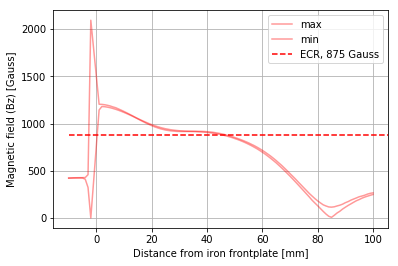

In [69]:
plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_max'], color='red', label='max', alpha=0.4)
plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_min'], color='red', label='min', alpha=0.4)

xlim = plt.gca().get_xlim()
plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR, 875 Gauss')
plt.legend()
plt.grid()
plt.xlabel('Distance from iron frontplate [mm]')
plt.ylabel('Magnetic field (Bz) [Gauss]')

# plt.ylim(0, ylim[1])
plt.xlim(xlim)
plt.show()

## Experiment and Simulation in comparison

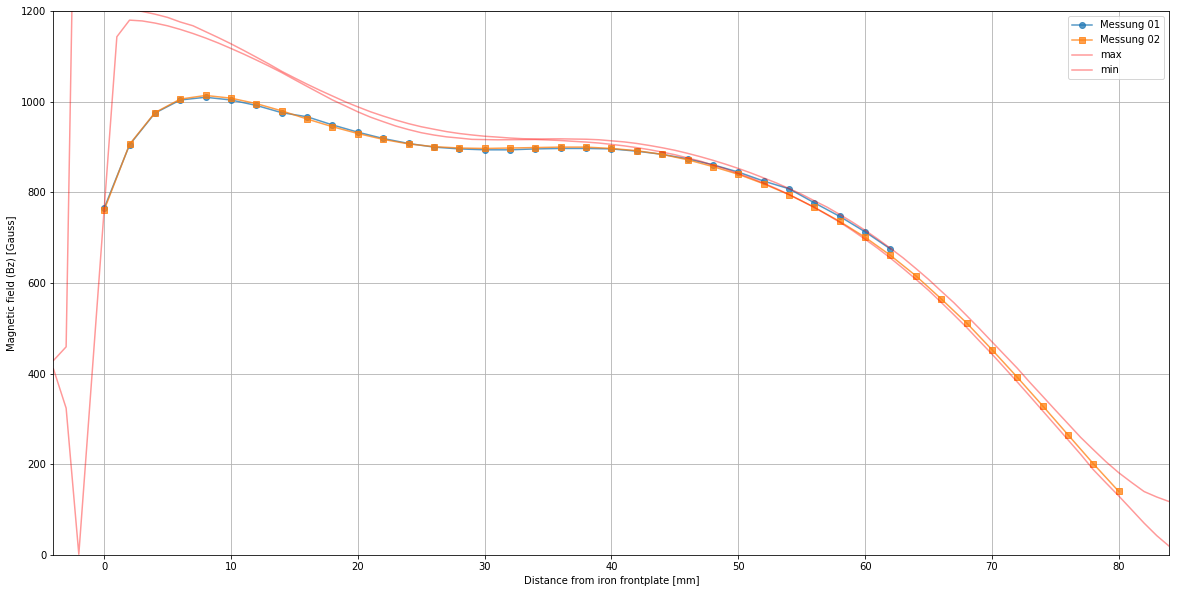

In [70]:
plt.figure(figsize=(20,10))
plt.plot(dfs[0].iloc[:,0], dfs[0].iloc[:,1], marker='o',label='Messung 01', alpha=0.75)

plt.plot(dfs[1].iloc[:,0], dfs[1].iloc[:,1], marker='s', label='Messung 02', alpha=0.75)

xlim = plt.gca().get_xlim()
plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_max'], color='red', label='max', alpha=0.4)
plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_min'], color='red', label='min', alpha=0.4)
# plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR, 875 Gauss')
plt.legend()
plt.grid()
plt.xlabel('Distance from iron frontplate [mm]')
plt.ylabel('Magnetic field (Bz) [Gauss]')
ylim = plt.gca().get_ylim()
plt.ylim(0, 1200)
plt.xlim(xlim)
plt.show()

## compare different relative iron plate values

In [39]:
path = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/'
fnames = os.listdir(path)
fnames = [f'{path}{f}' for f in fnames if f.endswith('csv')]
fnames

['/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron1200.1mmHole.csv',
 '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron1600.1mmHole.csv',
 '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron800.1mmHole.csv',
 '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron1800.1mmHole.csv',
 '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron1000.1mmHole.csv']

In [45]:
dfs = []
def find_max_Bfield(df):
    mymax = df['normB_Gauss'].max()
    mymin = df['normB_Gauss'].min()
    return pd.Series({'normB_Gauss_max': mymax, 'normB_Gauss_min': mymin})

for fname in fnames:
    ID = re.findall(r'Iron(\d+)\.', fname)[0]
    df_comsol = pd.read_csv(fname, skiprows=8)
    df_comsol.columns = ['x', 'y', 'z', 'normB_mT']
    df_comsol['normB_Gauss'] = df_comsol['normB_mT'] * 10
    df_comsol = df_comsol.sort_values(by=['x'])

    df_comsol_maxmin = df_comsol.groupby('x').apply(lambda x: find_max_Bfield(x))
    df_comsol_maxmin['ID'] = ID
    dfs.append(df_comsol_maxmin)

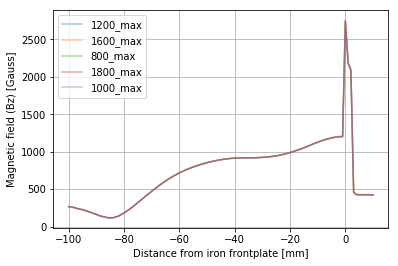

In [49]:
for df_comsol_maxmin in dfs:
    ID = df_comsol_maxmin.ID.unique()[0]
    plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_max'], label=f'{ID}_max', alpha=0.4)

xlim = plt.gca().get_xlim()
# plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR, 875 Gauss')
plt.legend()
plt.grid()
plt.xlabel('Distance from iron frontplate [mm]')
plt.ylabel('Magnetic field (Bz) [Gauss]')

# plt.ylim(0, ylim[1])
plt.xlim(xlim)
plt.show()

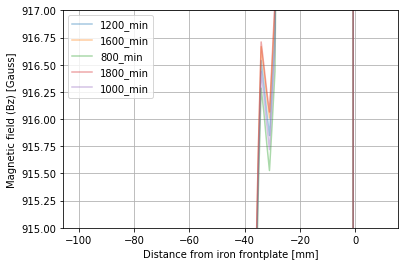

In [58]:
for df_comsol_maxmin in dfs:
    ID = df_comsol_maxmin.ID.unique()[0]
    plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_min'], label=f'{ID}_min', alpha=0.4)

xlim = plt.gca().get_xlim()
# plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR, 875 Gauss')
plt.legend()
plt.grid()
plt.xlabel('Distance from iron frontplate [mm]')
plt.ylabel('Magnetic field (Bz) [Gauss]')

plt.ylim(915,917)
plt.xlim(xlim)
plt.show()